### Rice Diseases Classification



### Load Data from kaggle

In [0]:
# from google.colab import files
# files.upload()

In [5]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

100% 12.0G/12.0G [02:04<00:00, 140MB/s]
100% 12.0G/12.0G [02:04<00:00, 103MB/s]


In [0]:
# !unzip rice-diseases-image-dataset.zip

### import libraries and preprocess data

In [20]:
import torch
from torch import nn, optim
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
import matplotlib.pyplot as plt
from glob import glob

%matplotlib inline


# check if cuda is available

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  print('CUDA is available.  Training on GPU ...')
else:
    print('CUDA is not available!  Training on CPU ...')

CUDA is available.  Training on GPU ...


In [0]:
data_dir = './LabelledRice/Labelled'

In [22]:
images = glob(os.path.join(data_dir, '*/*.jpg'))
total_images = len(images)
print('Total images:', total_images)

Total images: 3355


In [29]:
# number of images per class
image_count = []
class_names = []

for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    image_count.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)

Healthy              1488
Hispa                565
LeafBlast            779
BrownSpot            523


In [0]:
# define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224 + 32),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets=dict()
image_datasets['train']=datasets.ImageFolder(data_dir,transform=data_transforms['train'])
image_datasets['valid']=datasets.ImageFolder(data_dir,transform=data_transforms['valid'])

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# obtain training indices to use for validation
num_train = len(image_datasets['train'])
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# create dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['valid'] = valid_loader
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}


# specify class names
class_names = image_datasets['train'].classes

### Visualize the Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

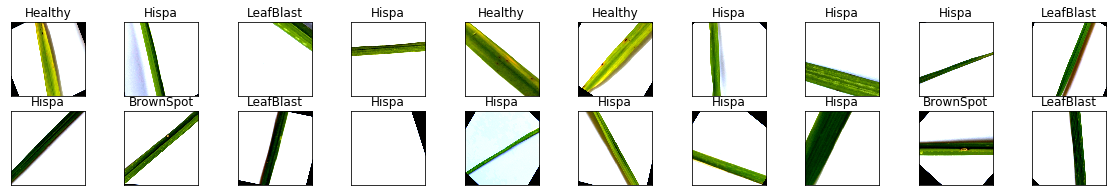

In [37]:
# helper function to un-normalize and display image
def imshow(img):
  img = img / 2 + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0))) #convert from tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in batch with their labels
fig = plt.figure(figsize=(20, 3))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(class_names[labels[idx]])


### Build and train the Classifier

Now the data is ready, we will now build the classifier, we will use pretrained models to achieve high accuracy with less time on training

In [0]:
# download the pretrained model

model_vgg = models.vgg16(pretrained=True)
for param in model_vgg.features.parameters():
    param.requires_grad = False
    
n_inputs = model_vgg.classifier[6].in_features
last_layer = nn.Sequential(nn.Linear(n_inputs, 512),
                                     nn.ReLU(True),
                                     nn.BatchNorm1d(512),
                                     nn.Dropout(0.5),
                                     nn.Linear(512, 4))
model_vgg.classifier[6] = last_layer


if train_on_gpu:
    model_vgg = model_vgg.cuda()

In [96]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.classifier.parameters(), lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vgg.to(device);

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        

        # train the model 
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
  
        # validate the model 
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model..'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    return model

In [100]:
model = train(10, dataloaders, model_vgg, optimizer, 
                      criterion, train_on_gpu, 'model.pt')

Epoch: 1 	Training Loss: 1.450331 	Validation Loss: 1.184002
Validation loss decreased (inf --> 1.184002). Saving model..
Epoch: 2 	Training Loss: 1.238650 	Validation Loss: 1.095775
Validation loss decreased (1.184002 --> 1.095775). Saving model..
Epoch: 3 	Training Loss: 1.200814 	Validation Loss: 1.049595
Validation loss decreased (1.095775 --> 1.049595). Saving model..
Epoch: 4 	Training Loss: 1.156758 	Validation Loss: 1.029246
Validation loss decreased (1.049595 --> 1.029246). Saving model..
Epoch: 5 	Training Loss: 1.127481 	Validation Loss: 0.979266
Validation loss decreased (1.029246 --> 0.979266). Saving model..
Epoch: 6 	Training Loss: 1.117779 	Validation Loss: 1.033201
Epoch: 7 	Training Loss: 1.106383 	Validation Loss: 1.012139
Epoch: 8 	Training Loss: 1.115334 	Validation Loss: 0.970260
Validation loss decreased (0.979266 --> 0.970260). Saving model..
Epoch: 9 	Training Loss: 1.096537 	Validation Loss: 0.964028
Validation loss decreased (0.970260 --> 0.964028). Saving mo

## Predict Plant Disease with the Model

In [0]:
from PIL import Image
import matplotlib.image as mpimg


def predict(img_path):
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    prediction = model_vgg(img)
    prediction = prediction.cpu().data.numpy().argmax()

    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

    print('Detected: {}'.format(class_names[prediction]))

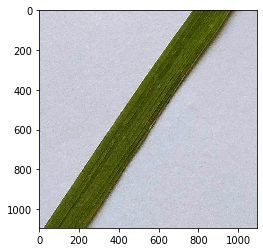

Detected: Healthy


In [128]:
import os
os.chdir("LabelledRice/Labelled")

predict('Healthy/IMG_20190419_135724.jpg')

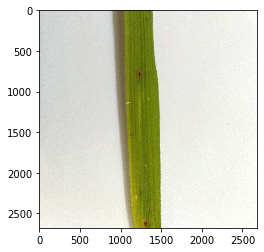

Detected: BrownSpot


In [130]:
predict('BrownSpot/IMG_20190420_195201.jpg')

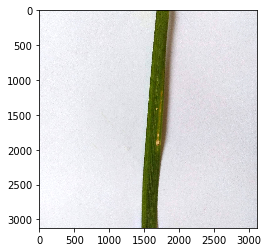

Detected: LeafBlast


In [145]:
predict('LeafBlast/IMG_20190419_173958.jpg')

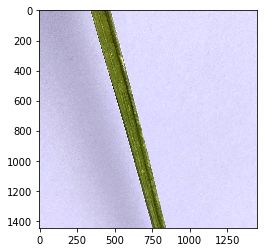

Detected: Hispa


In [189]:
predict('Hispa/IMG_20190419_105736.jpg')

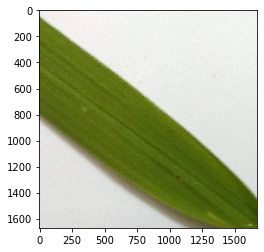

Detected: Healthy


In [192]:
predict('Healthy/IMG_20190420_194317.jpg')